In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,WeightedRandomSampler,SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import math

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=128),
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
trainDataset = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=train_transforms)
valDataset   = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=val_transforms)

targets = trainDataset.targets
#split by index, not the actual data
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), 
    test_size=0.2,           #80/20 split
    shuffle=True, 
    stratify=targets     #to keep the same distribution of classes in both sets
)

train_subset = Subset(trainDataset, train_idx)
val_subset   = Subset(valDataset, val_idx)

In [4]:
counter = Counter(trainDataset.targets)
for class_index, count in counter.most_common():
    class_name = trainDataset.classes[class_index]
    print(f"{class_name}: {count}")

boho: 918
eclectic: 809
modern: 809
farmhouse: 795
coastal: 794
mediterranean: 789
french-country: 788
contemporary: 782
asian: 779
southwestern: 772
tropical: 772
scandinavian: 768
craftsman: 764
industrial: 764
victorian: 759
shabby-chic-style: 746
minimalist: 555


In [5]:
train_targets = np.array(targets)[train_idx] #get all the training targets

#calculate the weights
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts

#map each label to its weight
sample_weights = class_weights[train_targets] #this create an array of len(train_targets), and its like every we are indexing by the target label 
sample_weights = torch.from_numpy(sample_weights).double()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [6]:
train_loader = DataLoader(
    train_subset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=32, 
    shuffle=False,        
    num_workers=4
)

In [7]:
print(f"Training on {len(train_subset)} images.")
print(f"Validating on {len(val_subset)} images.")

Training on 10530 images.
Validating on 2633 images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

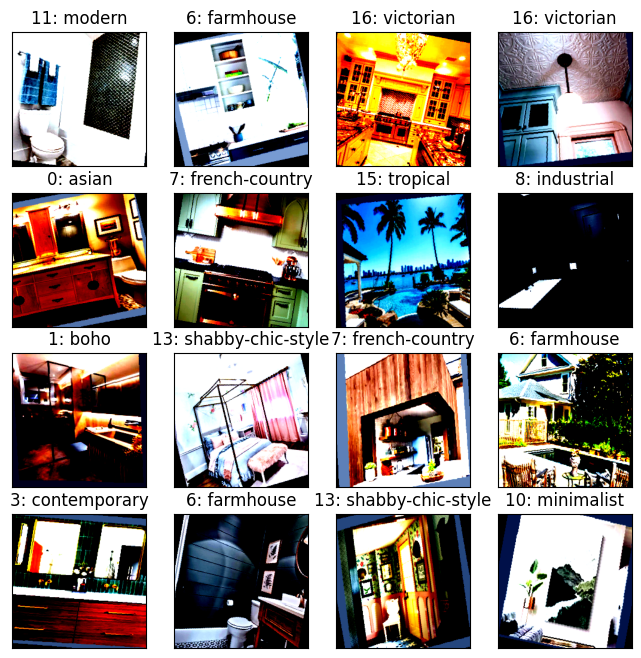

In [8]:
indoorStyleClasses = trainDataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = indoorStyleClasses[idx]
    
    ax.set_title(f"{idx}: {real_name}")

plt.show()

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (Batch, 768, 14, 14)
        x = x.flatten(2)  # (Batch, 768, 196)
        x = x.transpose(1, 2)  # (Batch, 196, 768)
        return x

In [10]:
class CustomViT(nn.Module):
    def __init__(self, num_classes=17, drop_rate=0.1):
        super().__init__()
        
        embed_dim = 768
        depth = 12
        heads = 12
        
        # 1. Patch Embedding
        self.patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=embed_dim)
        
        # 2. Tokens & Positional Embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=heads, 
            dim_feedforward=3072, 
            dropout=drop_rate, 
            activation='gelu', 
            batch_first=True,
            norm_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 4. Final Norm & Head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.constant_(self.head.bias, 0)

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Input Processing
        x = self.patch_embed(x)
        
        # Adding Tokens
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Encoder
        x = self.transformer_encoder(x)
        
        # Classification
        x = self.norm(x[:, 0]) 
        x = self.head(x)
        return x

In [11]:
def load_pretrained_weights(my_model):
    print("Loading ImageNet weights...")
    
    try:
        pretrained_weights = ViT_B_16_Weights.IMAGENET1K_V1.get_state_dict()
    except:
        print("Could not download weights automatically. Check internet.")
        return my_model

    my_state_dict = my_model.state_dict()
    new_state_dict = {}


    for k, v in pretrained_weights.items():
        
        if 'heads' in k:
            continue
            
        new_k = k
        
        new_k = new_k.replace('conv_proj', 'patch_embed.proj')
        new_k = new_k.replace('encoder.pos_embedding', 'pos_embed')
        new_k = new_k.replace('class_token', 'cls_token')
        new_k = new_k.replace('encoder.layers.encoder_layer_', 'transformer_encoder.layers.')
        new_k = new_k.replace('ln_1', 'norm1')
        new_k = new_k.replace('ln_2', 'norm2')
        new_k = new_k.replace('self_attention', 'self_attn')
        new_k = new_k.replace('mlp.linear_1', 'linear1')
        new_k = new_k.replace('mlp.linear_2', 'linear2')
        new_k = new_k.replace('encoder.ln', 'norm') 

        if new_k in my_state_dict:
            if v.shape == my_state_dict[new_k].shape:
                new_state_dict[new_k] = v
            else:
                print(f"Skipping {new_k} due to shape mismatch")
        else:
            pass
    msg = my_model.load_state_dict(new_state_dict, strict=False)
    print("Weights loaded successfully!")
    print(f"Missing keys (should be only head): {msg.missing_keys}")
    
    return my_model


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")



Working on device: cuda


In [13]:
model = CustomViT(num_classes=17).to(device)
model = load_pretrained_weights(model)
print("Model is ready for training with Pretrained Weights!")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


Loading ImageNet weights...


100%|██████████| 330M/330M [00:00<00:00, 355MB/s]


Weights loaded successfully!
Missing keys (should be only head): ['head.weight', 'head.bias']
Model is ready for training with Pretrained Weights!


In [14]:
num_epochs=20
criterion = nn.CrossEntropyLoss() 
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [15]:

best_val_acc=0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # === Training Phase ===
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total

    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print(f"--> New Best Model Saved! (Acc: {best_val_acc:.2f}%)")
    
    scheduler.step(epoch_val_loss)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.2f}%")
    print("-" * 50)

--> New Best Model Saved! (Acc: 34.45%)
Epoch [1/20]
Train Loss: 2.3203 | Train Acc: 26.17%
Val   Loss: 2.0794 | Val   Acc: 34.45%
--------------------------------------------------
--> New Best Model Saved! (Acc: 34.49%)
Epoch [2/20]
Train Loss: 1.8911 | Train Acc: 39.12%
Val   Loss: 2.0542 | Val   Acc: 34.49%
--------------------------------------------------
Epoch [3/20]
Train Loss: 1.6904 | Train Acc: 46.47%
Val   Loss: 2.2259 | Val   Acc: 33.84%
--------------------------------------------------
--> New Best Model Saved! (Acc: 35.40%)
Epoch [4/20]
Train Loss: 1.5009 | Train Acc: 51.86%
Val   Loss: 2.1357 | Val   Acc: 35.40%
--------------------------------------------------
Epoch [5/20]
Train Loss: 1.3344 | Train Acc: 57.83%
Val   Loss: 2.3545 | Val   Acc: 33.38%
--------------------------------------------------
Epoch [6/20]
Train Loss: 1.1673 | Train Acc: 62.94%
Val   Loss: 2.5555 | Val   Acc: 35.09%
--------------------------------------------------
--> New Best Model Saved! (A

In [16]:
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError 
from torch.utils.data import Dataset, DataLoader
import torch

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            print(f"Warning: Corrupted image found {img_name}. Using dummy black image.")
            image = Image.new('RGB', (224, 224), color='black')
            
        if self.transform:
            image = self.transform(image)
            
        return image, img_name

test_dir_path = '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test' 

if not os.path.exists(test_dir_path):
    print(f"Warning: Path {test_dir_path} not found!")
    
test_dataset = TestDataset(test_dir_path, transform=val_transforms) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Images Found: {len(test_dataset)}")

model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device) 
model.eval() 

predictions = []
image_names = []

print("Starting Prediction on Test Set...")

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for pred in predicted:

            predictions.append(pred.item()) 
            
        image_names.extend(names)

print("Prediction Completed.")

submission_df = pd.DataFrame({
    'ImageName': image_names,     
    'ClassLabel': predictions   
})

submission_df.to_csv('submission.csv', index=False)

print("SUCCESS: submission.csv created successfully with Integer Labels!")
print(submission_df.head()) 

Test Images Found: 5482
Starting Prediction on Test Set...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Prediction Completed.
SUCCESS: submission.csv created successfully with Integer Labels!
            ImageName  ClassLabel
0     testimage_1.jpg           9
1    testimage_10.jpg           7
2   testimage_100.jpg          10
3  testimage_1000.jpg           2
4  testimage_1001.jpg          10
